In [16]:
import pyaudio
import wave
import keyboard
import time
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from scipy import signal
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchaudio
import csv

RATE = 44100*2

In [27]:
class SiameseDataset(Dataset):
    def __init__(self, data_dir, combinations_descriptor):
        self.data_dir = data_dir
        self.file_names = os.listdir(data_dir)
        self.combinations_descriptor = combinations_descriptor
        self.combinations = []

        with open(self.combinations_descriptor, 'r') as fd:
            reader = csv.reader(fd)
            for row in reader:
                if len(row) != 0:
                    self.combinations.append(tuple(row))
                # else:
                    # print("Element is empty")

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self,index):
        # Get name of file
        pair = self.combinations[index]
        print(pair)
        file_0 = pair[0]
        file_1 = pair[1]

        file_0_path = os.path.join(self.data_dir, file_0)
        file_1_path = os.path.join(self.data_dir, file_1)

        # load the audio files
        waveform_0, sample_rate= torchaudio.load(file_0_path)
        waveform_1, sample_rate= torchaudio.load(file_1_path)
        # print(f'{file_0_path}, {file_1_path}')
        # print(waveform_0)
        
        
        # print(sample_rate)

        n_fft = 1024  # Size of the FFT window
        hop_length = 130  # Hop length for frame spacing
        n_mels = 64  # Number of Mel filterbanks

        # Create the MelSpectrogram transform
        mel_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=sample_rate,
            n_fft=n_fft,
            hop_length=hop_length,
            n_mels=n_mels
        )


        # Convert both samples to mel spectrograms
        mel_spectrogram_0 = mel_transform(waveform_0)
        # mel_spectrogram_0 = torch.squeeze(mel_spectrogram_0)
        mel_spectrogram_0 = torch.log10(mel_spectrogram_0)
        
        # print(waveform_1)
        mel_spectrogram_1 = mel_transform(waveform_1)
        # mel_spectrogram_1 = torch.squeeze(mel_spectrogram_1)
        mel_spectrogram_1 = torch.log10(mel_spectrogram_1)
        

        # print(f'{file_0}, {file_1}')

        # components = file_0.split('_')
        # print(f'label is {components[-2]}')
        label = int(pair[2])
        print(f'label is: {label}')

        # print(mel_spectrogram_0)
        
        return mel_spectrogram_0, mel_spectrogram_1, label


In [18]:
i = 0

5
('2023-06-27_12-47-29_i_(1).wav', '2023-06-27_12-47-29_i_(5).wav', '1')
label is: 1
<class 'torch.Tensor'>
torch.Size([1, 64, 64])


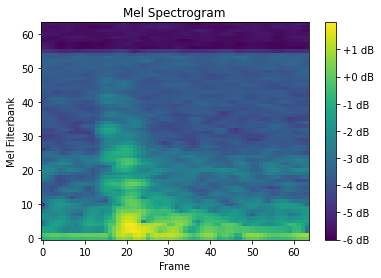

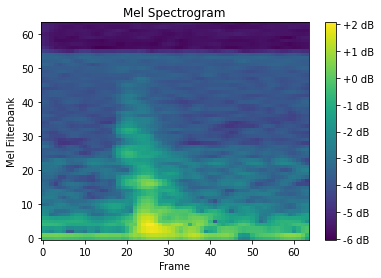

In [34]:
# Create an instance of the dataset
dataset = SiameseDataset("output", "key_press_pairs.csv")
print(i)
mel_spectrogram_0, mel_spectrogram_1, label = dataset[i]
i += 1

# DEBUG
print(type(mel_spectrogram_0))
print(mel_spectrogram_0.shape)

# Squeeze data
mel_spectrogram_0 = torch.squeeze(mel_spectrogram_0)
mel_spectrogram_1 = torch.squeeze(mel_spectrogram_1)


# Visualize the Mel spectrogram
mel_spectrogram_0 = mel_spectrogram_0.numpy()
plt.imshow(mel_spectrogram_0, aspect='auto', origin='lower')
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Frame')
plt.ylabel('Mel Filterbank')
plt.title('Mel Spectrogram')
plt.show()

# Visualize the Mel spectrogram
mel_spectrogram_1 = mel_spectrogram_1.numpy()
plt.imshow(mel_spectrogram_1, aspect='auto', origin='lower')
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Frame')
plt.ylabel('Mel Filterbank')
plt.title('Mel Spectrogram')
plt.show()

# print(torch.from_numpy(mel_spectrogram_0))

In [20]:
class SiameseKeySniffer(nn.Module):
    def __init__(self):
        super(SiameseKeySniffer, self).__init__()
        # Setting up the Sequential of CNN Layers
        # Starting dimension 64x64
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size = 5, stride = 1, padding = 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(32,32, kernel_size = 5, stride = 1, padding = 2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,stride=2),
            # dimension 32x32
            nn.Conv2d(64, 64, kernel_size = 5, stride = 1, padding = 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size = 5, stride = 1, padding = 2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,stride=2),
            # dimension 16x16
            nn.Conv2d(128, 128, kernel_size = 5, stride = 1, padding = 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size = 5, stride = 1, padding = 2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,stride=2),
            # dimension 8x8
            nn.Conv2d(256, 256, kernel_size = 5, stride = 1, padding = 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 512, kernel_size = 5, stride = 1, padding = 2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,stride=2),
            # dimension 4x4
            nn.Conv2d(512, 512, kernel_size = 5, stride = 1, padding = 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size = 5, stride = 1, padding = 2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,stride=2)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(512*4*4, 1024),
            nn.ReLU(inplace=True),

            nn.Linear(1024, 128),
            nn.ReLU(inplace=True),

            nn.Linear(128,2)
        )

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output
    
    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [21]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function
    Based on: https://towardsdatascience.com/a-friendly-introduction-to-siamese-networks-85ab17522942
    """

    def __init__(self,margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, x0, x1, y):
        diff = x0 - x1
        dist_sq = torch.sum(torch.pow(diff, 2), 1)
        dist = torch.sqrt(dist_sq)

        mdist = self.margin - dist
        dist = torch.clamp(mdist, min=0.0)
        loss = y * dist_sq + (1-y) * torch.pow(dist, 2)
        loss = torch.sum(loss) / 2.0 / x0.size()[0]
        return loss

In [30]:
# Train network

epochs = 20

# Declare siamese network
net = SiameseKeySniffer()#.cuda()
# Declare loss function
criterion = ContrastiveLoss()
# Declare the optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, weight_decay=0.0005)

# dataloaders
train_dataloader = SiameseDataset("output", "key_press_pairs.csv")

def train():
    loss = []
    counter = []
    iteration_number = 0
    for epoch in range(1, epochs):
        for i, data in enumerate(train_dataloader, 0):
            # these are the two key presses we are interested in for this iteration from our dataset
            press0, press1, label = data
            # press0, press1, label = press0.cuda(), press1.cuda(), label.cuda()
            optimizer.zero_grad()

            # Don't know why this isn't net.forward() I guess this is a pytorch syntax thing...
            output1, output2 = net.forward(press0, press1)
            loss_contrastive = criterion(output1, output2, label)
            loss_contrastive.backward()
            optimizer.step()
        print(f"Epoch {epoch}\n Current loss {loss_contrastive.item()}")
        iteration_number += 10
        counter.append(iteration_number)
        loss.append(loss_contrastive.item())
    print(counter)
    # Turn this into a plot
    return net

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = train()
torch.save(model.state_dict(), "model.pt")
print("Model Saved Successfully") 

('2023-06-27_12-47-29_space_(38).wav', '2023-06-27_12-47-29_space_(9).wav', '1')
label is: 1


RuntimeError: Given groups=1, weight of size [64, 64, 5, 5], expected input[1, 32, 32, 32] to have 64 channels, but got 32 channels instead